In [1]:
# imports

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import scipy as sp
import scipy.linalg as la

import pystan
import stan_utility
import arviz as az
import scipy.stats as stats

In [2]:
# constants

N_SAMP = 10000
SEED = 74337
BINS = np.linspace(0,50,100)

# Using Stan language to sapmple various probability distributions or solve algebraic equations

## Sampling gamma distribution

$\Gamma( \alpha ,\beta)$

In [3]:
with open('gamma_sampler.stan', 'r') as file:
    print(file.read())

data {
  real alpha;
  real beta;
}

generated quantities {
  real <lower=0> samples = gamma_rng(alpha, beta);
}



In [4]:
gamma_sampler = stan_utility.compile_model('gamma_sampler.stan')

Using cached StanModel


In [5]:
df = pd.DataFrame()
BINS = np.linspace(0,50,100)

# defining paramaters
alpha = [1, 3, 10, 25]
beta = [1, 2, 5]

# sampling pdf with above params
for _alpha in alpha:
    for _beta in beta:
        data = {'alpha': _alpha, 'beta': _beta}
        # sampling from compiled stan model
        sim = gamma_sampler.sampling(data=data,                
                                     algorithm="Fixed_param",  
                                     iter=N_SAMP,     
                                     warmup=0, 
                                     chains=1, 
                                     refresh=N_SAMP,
                                     seed=SEED)
        # extracting from simulation
        params = sim.extract()
        samples = params['samples']
        # orginizng data in dataframe
        df.loc[:,r'{},{}'.format(_alpha, _beta)] = samples

In [6]:
melted = pd.melt(df)

# some mumbo-jumbo so that TeX symbols appear in plots
temp = melted.loc[:,'variable'].str.split(',', expand=True)
melted.loc[:,r'$\alpha$'] = temp[0]
melted.loc[:,r'$\beta$'] = temp[1]
del temp
melted = melted.drop(columns=['variable'])

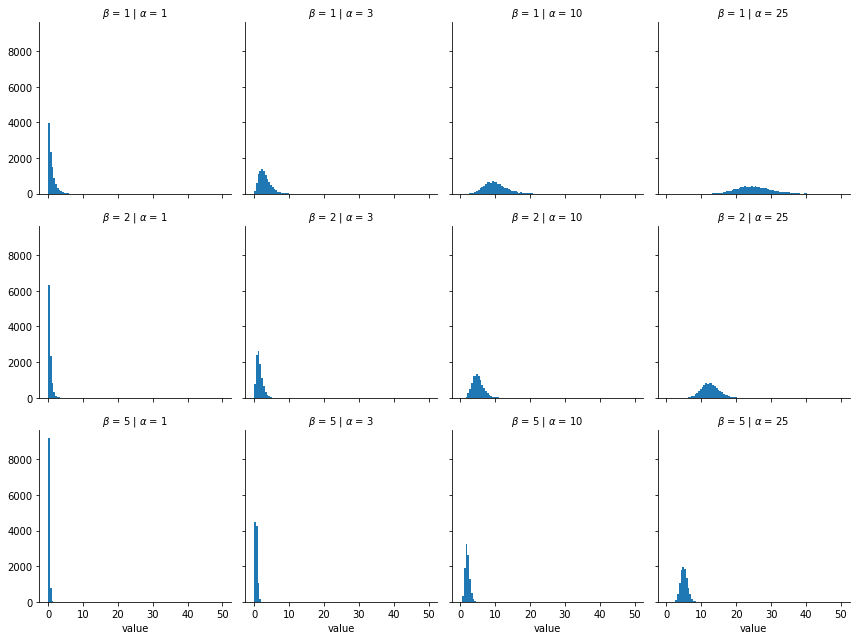

In [7]:
# creating plot
f = sns.FacetGrid(melted,
                  col=r'$\alpha$', 
                  row=r'$\beta$',
                  col_order=list(str(i) for i in alpha),
                  row_order=list(str(i) for i in beta))
f = f.map(plt.hist, 'value', bins=BINS)

## Sampling inverse gamma distribution

$\Gamma( \alpha ,\beta)$

In [8]:
with open('inv_gamma_sampler.stan', 'r') as file:
    print(file.read())

data {
  real alpha;
  real beta;
}

generated quantities {
  real <lower=0> samples = inv_gamma_rng(alpha, beta);
}




In [9]:
inv_gamma_sampler = stan_utility.compile_model('inv_gamma_sampler.stan')

Using cached StanModel


In [10]:
df = pd.DataFrame()
BINS = np.linspace(0,10,100)

# defining paramaters
alpha = [1, 3, 10, 25]
beta = [1, 2, 5]

# sampling pdf with above params
for _alpha in alpha:
    for _beta in beta:
        data = {'alpha': _alpha, 'beta': _beta}
        # sampling from compiled stan model
        sim = inv_gamma_sampler.sampling(data=data,
                                         algorithm="Fixed_param",
                                         iter=N_SAMP,
                                         warmup=0,
                                         chains=1,
                                         refresh=N_SAMP,
                                         seed=SEED)
        # extracting from simulation
        params = sim.extract()
        samples = params['samples']
        # orginizng data in dataframe
        df.loc[:,r'{},{}'.format(_alpha, _beta)] = samples

In [11]:
melted = pd.melt(df)

# some mumbo-jumbo so that TeX symbols appear in plots
temp = melted.loc[:,'variable'].str.split(',', expand=True)
melted.loc[:,r'$\alpha$'] = temp[0]
melted.loc[:,r'$\beta$'] = temp[1]
del temp
melted = melted.drop(columns=['variable'])

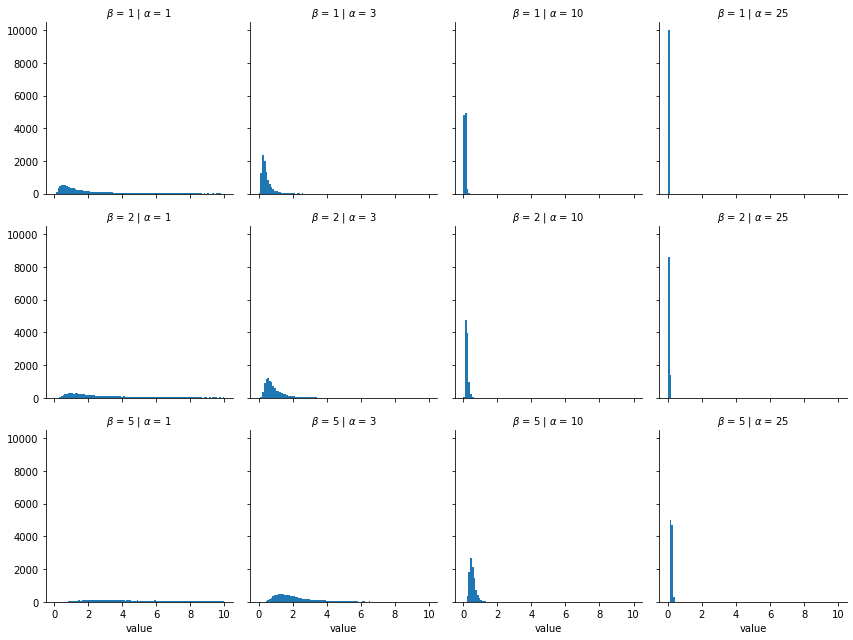

In [12]:
# creating plot
f = sns.FacetGrid(melted,
                  col=r'$\alpha$',
                  row=r'$\beta$',
                  col_order=list(str(i) for i in alpha),
                  row_order=list(str(i) for i in beta))
f = f.map(plt.hist, 'value', bins=BINS)

## Using Stan algebraic solver to find $\Gamma$ distribution parameters
such that 98% of samples are between 5 and 10

So, we assume that cdf at 5 is 0.01 and cdf at 10 is 0.99

In [13]:
with open('gamma_tuner.stan', 'r') as file:
    print(file.read())

functions {
  // Difference between Gamma probability and target probability
  
  vector gamma_delta(vector params, vector x, real[] x_r, int[] x_i) {
    vector[2] deltas;
    deltas[1] = gamma_cdf(x[1], exp(params[1]), exp(params[2]))- 0.01;
    deltas[2] = gamma_cdf(x[2], exp(params[1]), exp(params[2]))- 0.99;
    return deltas;
  }
}

data {
  vector[2] parameters_guess; // Initial guess of Gamma distribution parameters
  vector[2] theta;   // Target quantiles
}

transformed data {

  vector[2] y;
  real x_r[0];
  int x_i[0];

  // Find Gaussian standard deviation that ensures 99% probabilty below 15
  y = algebra_solver(gamma_delta, parameters_guess, theta, x_r, x_i);

}

generated quantities {
  real alpha = exp(y[1]);
  real beta = exp(y[2]);
}



In [14]:
gamma_tuner = stan_utility.compile_model('gamma_tuner.stan')

Using cached StanModel


In [15]:
beta_guess = 0.2
alpha_guess = 25

x1 = 5
x2 = 10
data = {'parameters_guess': np.array([np.log(alpha_guess), 
                                      np.log(beta_guess)]), 
        'theta': np.array([x1, x2])
       }

In [16]:
# sampling from compiled stan model
sim = gamma_tuner.sampling(data=data,                
                           algorithm="Fixed_param",  
                           iter=1,     
                           warmup=0, 
                           chains=1, 
                           refresh=1,
                           seed=SEED)

In [17]:
# extracting from simulation
params = sim.extract()
alpha = params['alpha']
beta = params['beta']
print('alpha = {}'.format(alpha[0]))
print('beta = {}'.format(beta[0]))

alpha = 45.63190460884883
beta = 6.279939507472603


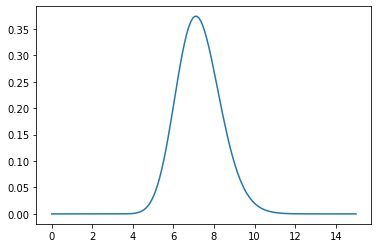

In [18]:
x = np.linspace(0, 15, 150)
y = stats.gamma.pdf(x, a = alpha, scale = 1/beta)
plt.plot(x,y)

## Using Stan algebraic solver to find inverse Gamma distribution parameters
such that 98% of samples are between 5 and 10

So, we assume that cdf at 5 is 0.01 and cdf at 10 is 0.99

In [19]:
with open('inv_gamma_tuner.stan', 'r') as file:
    print(file.read())

functions {
  // Difference between Gamma probability and target probability

  vector gamma_delta(vector params, vector x, real[] x_r, int[] x_i) {
    vector[2] deltas;
    deltas[1] = inv_gamma_cdf(x[1], exp(params[1]), exp(params[2]))- 0.01;
    deltas[2] = inv_gamma_cdf(x[2], exp(params[1]), exp(params[2]))- 0.99;
    return deltas;
  }
}

data {
  vector[2] parameters_guess; // Initial guess of Gamma distribution parameters
  vector[2] theta;   // Target quantiles
}

transformed data {

  vector[2] y;
  real x_r[0];
  int x_i[0];

  // Find Gaussian standard deviation that ensures 99% probabilty below 15
  y = algebra_solver(gamma_delta, parameters_guess, theta, x_r, x_i);

}

generated quantities {
  real alpha = exp(y[1]);
  real beta = exp(y[2]);
}



In [20]:
inv_gamma_tuner = stan_utility.compile_model('inv_gamma_tuner.stan')

Using cached StanModel


In [21]:
beta_guess = 75
alpha_guess = 5

x1 = 5
x2 = 10
data = {'parameters_guess': np.array([np.log(alpha_guess),
                                      np.log(beta_guess)]), 
        'theta': np.array([x1, x2])
       }

In [22]:
# sampling from compiled stan model
sim = inv_gamma_tuner.sampling(data=data,                
                               algorithm="Fixed_param",  
                               iter=1,     
                               warmup=0, 
                               chains=1, 
                               refresh=1,
                               seed=SEED)

In [23]:
# extracting from simulation
params = sim.extract()
alpha_inv = params['alpha']
beta_inv = params['beta']
print('alpha = {}'.format(alpha_inv[0]))
print('beta = {}'.format(beta_inv[0]))

alpha = 45.631904608833366
beta = 313.99697537360476


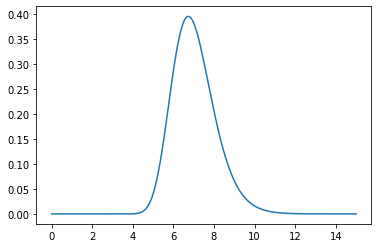

In [24]:
x = np.linspace(0, 15, 150)
y = stats.invgamma.pdf(x, a = alpha_inv, scale = beta_inv)
plt.plot(x,y)

## Comparing the histograms


In [25]:
df = pd.DataFrame()

# defining paramaters

data = {'alpha': alpha[0], 'beta': beta[0]}
# sampling from compiled stan model
sim = gamma_sampler.sampling(data=data,
                              algorithm="Fixed_param",
                              iter=N_SAMP,
                              warmup=0,
                              chains=1,
                              refresh=N_SAMP,
                              seed=SEED)
# extracting from simulation
params = sim.extract()
samples = params['samples']
# orginizng data in dataframe
df.loc[:,r'X~Gamma($\alpha=${:.1f}; $\beta=${:.1f})'.format(alpha[0], beta[0])] = samples

data = {'alpha': alpha_inv[0], 'beta': beta_inv[0]}
# sampling from compiled stan model
sim = inv_gamma_sampler.sampling(data=data,
                                 algorithm="Fixed_param",
                                 iter=N_SAMP,
                                 warmup=0,
                                 chains=1,
                                 refresh=N_SAMP,
                                 seed=SEED)
# extracting from simulation
params = sim.extract()
samples = params['samples']
# orginizng data in dataframe
df.loc[:,r'X~InvGamma($\alpha=${:.1f}, $\beta=${:.1f})'.format(alpha_inv[0], beta_inv[0])] = samples

In [26]:
melted = pd.melt(df)

/home/bgondek/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


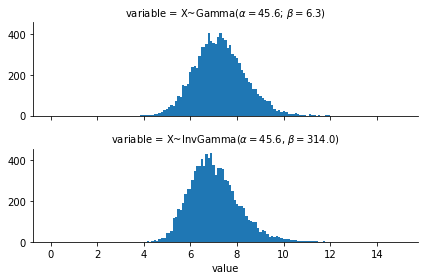

In [27]:
# creating plot
BINS = np.linspace(0, 15, 150)

f = sns.FacetGrid(melted,
                  row='variable',
                  sharex=True,
                  size=2,
                  aspect=3)
f = f.map(plt.hist, 'value', bins=BINS)

Samples from inverse gamma distribution are skewed towards 0.
This may be caused by the fact that samples from inverse gamma distribution in fact are inverse of the samples from gamma distribution.
Evenly spaced samples on linear scale after inverting their values will be more dense on side closer to 0.

## Sampling the negative binominal distribution:



- using concentration parametrization:<br/>
$X \sim \pi(x;\mu,\phi) = \binom{x+\phi-1}{x}\Big(\frac{\mu}{\mu+\phi}\Big)^x\Big(\frac{\phi}{\phi+\mu}\Big)^\phi$<br/>
Where:
 - $\mu$ is mean
 - $\phi$ is concentration parameter

In [28]:
with open('neg_binom_sampler.stan', 'r') as file:
    print(file.read())

data {
  real mu;
  real phi;
}

generated quantities {
  real samples = neg_binomial_2_rng(mu, phi);
}



In [29]:
with open('poisson_sampler.stan', 'r') as file:
    print(file.read())

data {
  int lambda;
}

generated quantities {
  int <lower=0> samples = poisson_rng(lambda);
}



In [30]:
neg_binom_sampler = stan_utility.compile_model('neg_binom_sampler.stan')
poisson_sampler = stan_utility.compile_model('poisson_sampler.stan')

Using cached StanModel
Using cached StanModel


In [31]:
df = pd.DataFrame()

# defining paramaters
mu = 10
distribution = ['Neg_binom', 'Poisson']
phi = [0.2, 1, 2, 5, 10000]

# sampling pdf with above params
for _d in distribution:
    for _phi in phi:
        if _d == 'Neg_binom':
            data = {'mu': mu, 'phi': _phi}
            # sampling from compiled stan model
            sim = neg_binom_sampler.sampling(data=data,
                                                algorithm="Fixed_param",
                                                iter=N_SAMP,
                                                warmup=0,
                                                chains=1,
                                                refresh=N_SAMP,
                                                seed=SEED)

                                                
        elif _d == 'Poisson':
            data = {'lambda': mu}
            # sampling from compiled stan model
            sim = poisson_sampler.sampling(data=data,
                                           algorithm="Fixed_param",
                                           iter=N_SAMP,
                                           warmup=0,
                                           chains=1,
                                           refresh=N_SAMP,
                                           seed=SEED)
            
        # extracting from simulation
        params = sim.extract()
        samples = params['samples']
        # orginizng data in dataframe
        df.loc[:,r'{} $\mu = 10$,{}'.format(_d, _phi)] = samples

In [32]:
melted = pd.melt(df)

# some mumbo-jumbo so that TeX symbols appear in plots
temp = melted.loc[:,'variable'].str.split(',', expand=True)
melted.loc[:,'Distribution'] = temp[0]
melted.loc[:,r'$\phi$'] = temp[1]
del temp
melted = melted.drop(columns=['variable'])

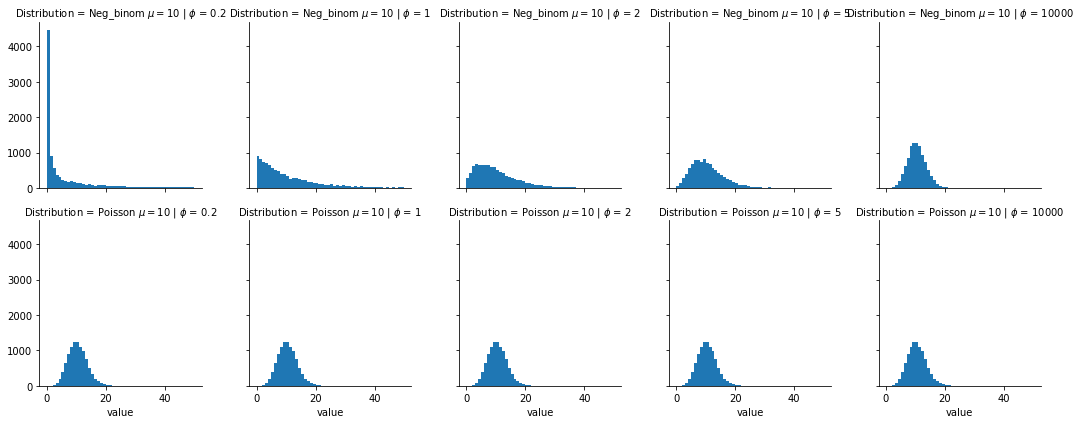

In [33]:
# creating plot
BINS = np.linspace(start=0, stop=50, num=51)
f = sns.FacetGrid(melted,
                  col=r'$\phi$',
                  row='Distribution',
                  col_order=list(str(i) for i in phi))
f = f.map(plt.hist, 'value', bins=BINS)

$\phi$ parameter near poisson distribution labels is just an outcome of Seaborn FacetGrid automatic labeling

In [34]:
melted

,value,Distribution,$\phi$
0,7.0,Neg_binom $\mu = 10$,0.2
1,1.0,Neg_binom $\mu = 10$,0.2
2,0.0,Neg_binom $\mu = 10$,0.2
3,4.0,Neg_binom $\mu = 10$,0.2
4,7.0,Neg_binom $\mu = 10$,0.2
...,...,...,...
99995,12.0,Poisson $\mu = 10$,10000
99996,11.0,Poisson $\mu = 10$,10000
99997,8.0,Poisson $\mu = 10$,10000
99998,10.0,Poisson $\mu = 10$,10000


- using dispersion parametrization:<br/>
$X \sim \pi(x;\mu,\psi) = \binom{x+\psi^{-1}-1}{x}\Big(\frac{\mu\psi}{\mu\psi+1}\Big)^x\Big(\frac{1}{\mu\psi+1}\Big)^\frac{1}{\psi}$<br/>
Where:
 - $\mu$ is mean
 - $\psi$ is dispersion parameter equal to inverse of the concentration parameter $\phi$ <br/>
 $\psi=\frac{1}{\phi}$


In [35]:
df = pd.DataFrame()

# defining paramaters
mu = 10
distribution = ['Neg_binom', 'Poisson']
psi = [0.2, 1, 2, 5, 10000]

# sampling pdf with above params
for _d in distribution:
    for _psi in psi:
        if _d == 'Neg_binom':
            data = {'mu': mu, 'phi': 1/_psi}
            # sampling from compiled stan model
            sim = neg_binom_sampler.sampling(data=data,
                                                algorithm="Fixed_param",
                                                iter=N_SAMP,
                                                warmup=0,
                                                chains=1,
                                                refresh=N_SAMP,
                                                seed=SEED)


        elif _d == 'Poisson':
            data = {'lambda': mu}
            # sampling from compiled stan model
            sim = poisson_sampler.sampling(data=data,
                                           algorithm="Fixed_param",
                                           iter=N_SAMP,
                                           warmup=0,
                                           chains=1,
                                           refresh=N_SAMP,
                                           seed=SEED)

        # extracting from simulation
        params = sim.extract()
        samples = params['samples']
        # orginizng data in dataframe
        df.loc[:,r'{} $\mu = 10$,{}'.format(_d, 1/_psi)] = samples

In [36]:
melted = pd.melt(df)

# some mumbo-jumbo so that TeX symbols appear in plots
temp = melted.loc[:,'variable'].str.split(',', expand=True)
melted.loc[:,'Distribution'] = temp[0]
melted.loc[:,r'$\psi$'] = temp[1]
del temp
melted = melted.drop(columns=['variable'])

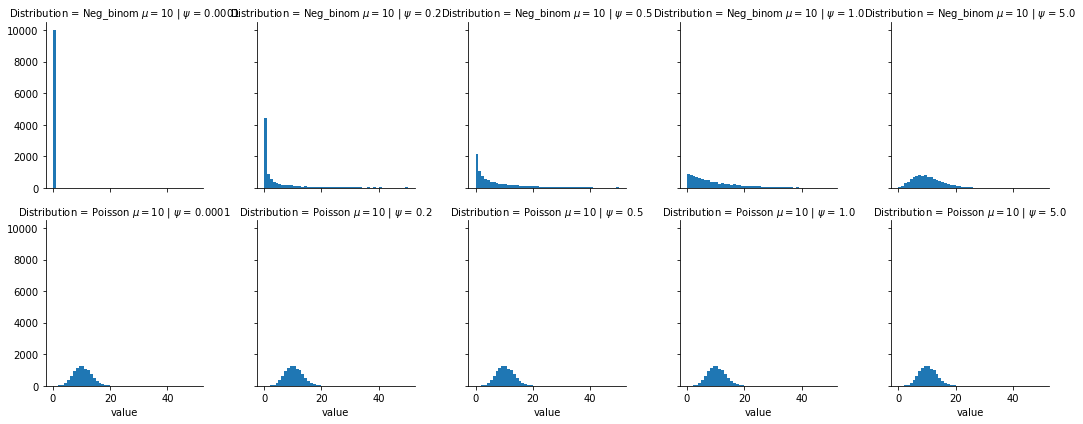

In [37]:
# creating plot
BINS = np.linspace(start=0, stop=50, num=51)
f = sns.FacetGrid(melted,
                  col=r'$\psi$',
                  row='Distribution')
                  #col_order=list(str(i) for i in psi))
f = f.map(plt.hist, 'value', bins=BINS)

## Sampling the Student-t distribution:



- using degrees of freedom parametrization:<br/>
$ X \sim \pi(x;\nu, \mu,\sigma) =
\frac{1}{\sqrt{\pi\nu\sigma^2}}
\frac{\Gamma(\frac{\nu+1}{2})}{\Gamma(\frac{\nu}{2})}
\Big(1 + \frac{1}{\nu}\big( \frac{x-\mu}{\sigma} \big)^{2} \Big)^{-\frac{\nu+1}{2}}$
Where:
 - $\nu$ is degrees of freedom
 - $\mu$ is location
 - $\sigma$ is scale

In [38]:
with open('student-t_sampler.stan', 'r') as file:
    print(file.read())

data {
  real nu;
  real mu;
  real sigma;
}

generated quantities {
  real samples = student_t_rng(nu, mu, sigma);
}


In [39]:
student_sampler = stan_utility.compile_model('student-t_sampler.stan')

Using cached StanModel


In [40]:
df = pd.DataFrame()



# defining paramaters
nu = [0.1, 1, 3, 10, 10000]
sigma = [1, 2, 5]
mu = 0
# sampling pdf with above params
for _nu in nu:
    for _sigma in sigma:
        data = { 'nu': _nu,'mu': mu, 'sigma': _sigma}
        # sampling from compiled stan model
        sim = student_sampler.sampling(data=data,
                                       algorithm="Fixed_param",
                                       iter=N_SAMP,
                                       warmup=0,
                                       chains=1,
                                       refresh=N_SAMP,
                                       seed=SEED)
        # extracting from simulation
        params = sim.extract()
        samples = params['samples']
        # orginizng data in dataframe
        df.loc[:,r'{}$\mu = 0 $,{}'.format(_nu, _sigma)] = samples

In [41]:
melted = pd.melt(df)

# some mumbo-jumbo so that TeX symbols appear in plots
temp = melted.loc[:,'variable'].str.split(',', expand=True)
melted.loc[:,r'$\nu$'] = temp[0]
melted.loc[:,r'$\sigma$'] = temp[1]
del temp
melted = melted.drop(columns=['variable'])

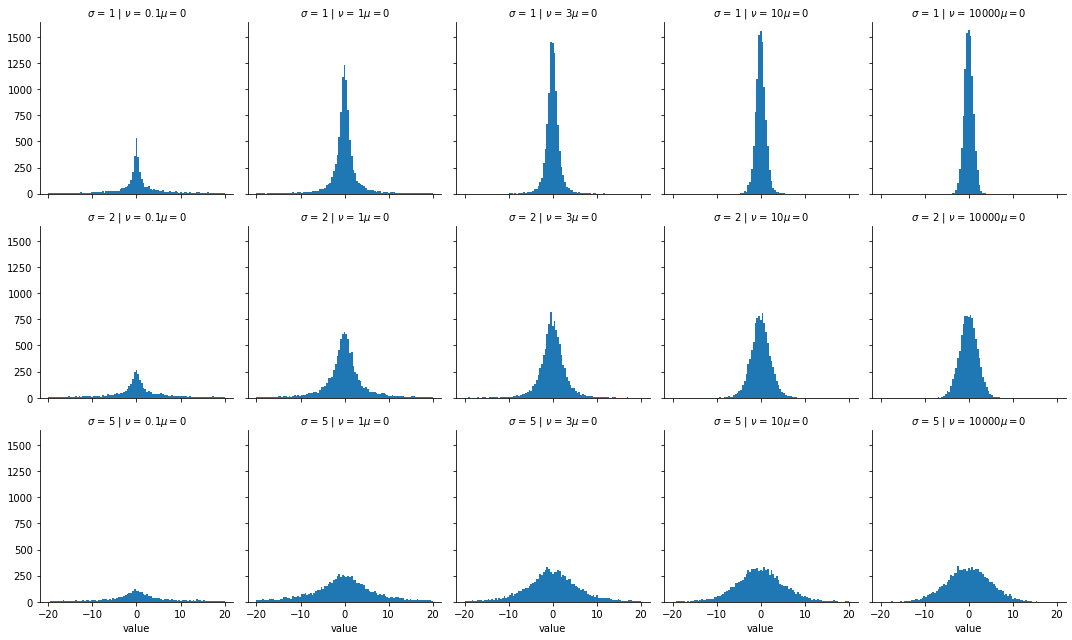

In [42]:
BINS = np.linspace(-20,20,100)
# creating plot
f = sns.FacetGrid(melted,
                  col=r'$\nu$',
                  row=r'$\sigma$')#,
                  #col_order=list(str(i) for i in nu),
                  #row_order=list(str(i) for i in sigma))
f = f.map(plt.hist, 'value', bins=BINS)

- using dispersion parametrization:<br/>
$ X \sim \pi(x;\nu, \mu,\sigma) =
\sqrt{\frac{\upsilon}{\pi\nu\sigma^2}}
\frac{\Gamma\big(\frac{1+\upsilon}{2\upsilon}\big)}{\Gamma\big(\frac{1}{2\upsilon}\big)}
\bigg(1 + \upsilon\big( \frac{x-\mu}{\sigma} \big)^{2} \bigg)^{-\frac{1+\upsilon}{2\upsilon}}$<br/>
Where:
 - $\upsilon$ is dispersion parameter equal to inverse of degrees of freedom<br/>
 $\upsilon=\frac{1}{\nu}$
 - $\mu$ is location
 - $\sigma$ is scale

In [43]:
df = pd.DataFrame()



# defining paramaters
nu = [0.1, 1, 3, 10, 100]
sigma = [1, 2, 5]
mu = 0
# sampling pdf with above params
for _nu in nu:
    for _sigma in sigma:
        data = { 'nu': 1/_nu,'mu': mu, 'sigma': _sigma}
        # sampling from compiled stan model
        sim = student_sampler.sampling(data=data,
                                       algorithm="Fixed_param",
                                       iter=N_SAMP,
                                       warmup=0,
                                       chains=1,
                                       refresh=N_SAMP,
                                       seed=SEED)
        # extracting from simulation
        params = sim.extract()
        samples = params['samples']
        # orginizng data in dataframe
        df.loc[:,r'{} $\mu = 0 $,{}'.format(_nu, _sigma)] = samples

In [44]:
melted = pd.melt(df)

# some mumbo-jumbo so that TeX symbols appear in plots
temp = melted.loc[:,'variable'].str.split(',', expand=True)
melted.loc[:,r'$\upsilon$'] = temp[0]
melted.loc[:,r'$\sigma$'] = temp[1]
del temp
melted = melted.drop(columns=['variable'])

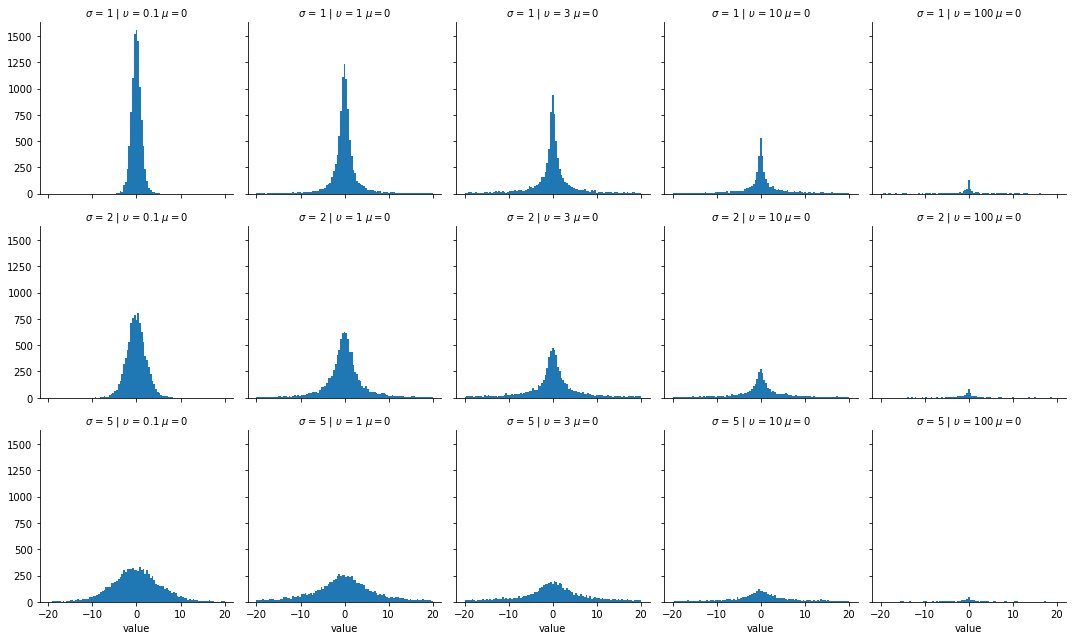

In [45]:
BINS = np.linspace(-20,20,100)
# creating plot
f = sns.FacetGrid(melted,
                  col=r'$\upsilon$',
                  row=r'$\sigma$')#,
                  #col_order=list(str(i) for i in nu),
                  #row_order=list(str(i) for i in sigma))
f = f.map(plt.hist, 'value', bins=BINS)

## Comparing the Student-T distributions (with different degrees of freedom) with normal distribution with the same $\mu$ and $\sigma$ parameters

In [46]:
with open('normal_sampler.stan', 'r') as file:
    print(file.read())

data {
  real mu;
  real sigma;
}

generated quantities {
  real samples = normal_rng(mu, sigma);
}


In [47]:
normal_sampler = stan_utility.compile_model('normal_sampler.stan')

Using cached StanModel


In [48]:
df = pd.DataFrame()

# defining paramaters
mu = 0
sigma = 1
distribution = ['Student-T', 'Normal']
nu = [0.1, 1, 100, 10000]

# sampling pdf with above params
for _d in distribution:
    for _nu in nu:
        if _d == 'Student-T':
            data = { 'nu': _nu,'mu': mu, 'sigma': sigma}
        # sampling from compiled stan model
            sim = student_sampler.sampling(data=data,
                                           algorithm="Fixed_param",
                                           iter=N_SAMP,
                                           warmup=0,
                                           chains=1,
                                           refresh=N_SAMP,
                                           seed=SEED)

        elif _d == 'Normal':
            data = {'mu': mu, 'sigma': sigma}
            # sampling from compiled stan model
            sim = normal_sampler.sampling(data=data,
                                           algorithm="Fixed_param",
                                           iter=N_SAMP,
                                           warmup=0,
                                           chains=1,
                                           refresh=N_SAMP,
                                           seed=SEED)

        # extracting from simulation
        params = sim.extract()
        samples = params['samples']
        # orginizng data in dataframe
        df.loc[:,r'{} $\mu = 0$ $\sigma = 1$, {}'.format(_d, _nu)] = samples

In [49]:
melted = pd.melt(df)

# some mumbo-jumbo so that TeX symbols appear in plots
temp = melted.loc[:,'variable'].str.split(',', expand=True)
melted.loc[:,'Dist'] = temp[0]
melted.loc[:,r'$\nu$'] = temp[1]
del temp
melted = melted.drop(columns=['variable'])

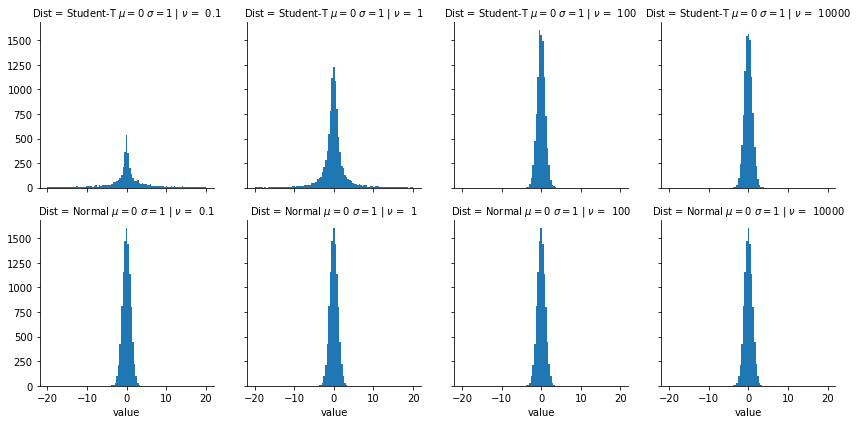

In [50]:
# creating plot
BINS = np.linspace(start=-20, stop=20, num=100)
f = sns.FacetGrid(melted,
                  col=r'$\nu$',
                  row='Dist')
                  #col_order=list(str(i) for i in psi))
f = f.map(plt.hist, 'value', bins=BINS)

As we increase the degrees of freedom, Student-T distribution becomes more similar to Normal distribution

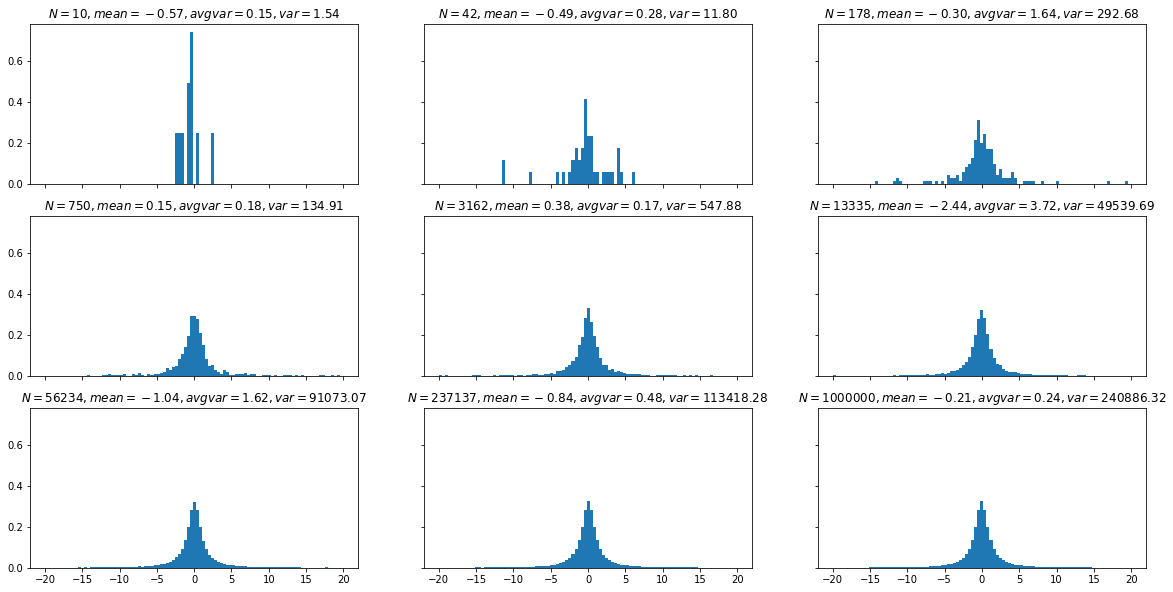

In [90]:
df = pd.DataFrame()

n = np.logspace(1,6,9)

# defining paramaters
nu = 1
sigma = 1
mu = 0

fig, axes = plt.subplots(ncols=3,
                         nrows=3,
                         sharex=True,
                         sharey=True,
                         figsize=(20,10))

# sampling pdf with above params

for i in range(len(n)):
    N=int(np.round(n[i]))
    
    data = { 'nu': nu,'mu': mu, 'sigma': sigma}
    # sampling from compiled stan model
    sim = student_sampler.sampling(data=data,
                                   algorithm="Fixed_param",
                                   iter=N,
                                   warmup=0,
                                   chains=1,
                                   refresh=N,
                                   seed=SEED)
    # extracting from simulation
    params = sim.extract()
    samples = params['samples']
    # orginizng data in dataframe
    axes[i//3, i%3].hist(samples, bins=BINS, density=True)
    axes[i//3, i%3].set_title(r'$N = {}, mean = {:.2f}, avg var = {:.2f}, var = {:.2f}$'.format(N, samples.mean(), samples.var()/N, samples.var()))

## Sampling the Multivariate Normal distribution:

Standard definition of ultivariate normal distribution is <br/>
$X \sim \pi(x;\mathbf{\mu},\mathbf{\Sigma}) =
\Big( 2\pi|\mathbf\Sigma|\Big)^{-\frac{1}{2}}
\exp{\Big( -\frac{1}{2}(\mathbf x-\mathbf\mu)^T\mathbf\Sigma^{-1}(\mathbf x-\mathbf\mu) \Big)}$

correlation decomposition of covariance matrix:<br/>
$\mathbf\Sigma = \mathbf L\cdot diag(\mathbf\tau)\cdot diag(\mathbf\tau)\cdot \mathbf L^{T}$ <br/>
Where:
 - $\mathbf L$ is Cholesky factor of $\mathbf\Psi$ correlation matrix
 - $\mathbf{\tau}$ is component scales vector


In [51]:
with open('multi_normal_sampler.stan', 'r') as file:
    print(file.read())

data {
  int N;
  vector[N] mu;
  matrix[N, N] L;
  matrix[N, N] diag_T;
}

generated quantities {
  vector[N] samples = multi_normal_rng(mu, L*diag_T*diag_T*(L'));
}



In [52]:
multi_normal_sampler = stan_utility.compile_model('multi_normal_sampler.stan')

Using cached StanModel


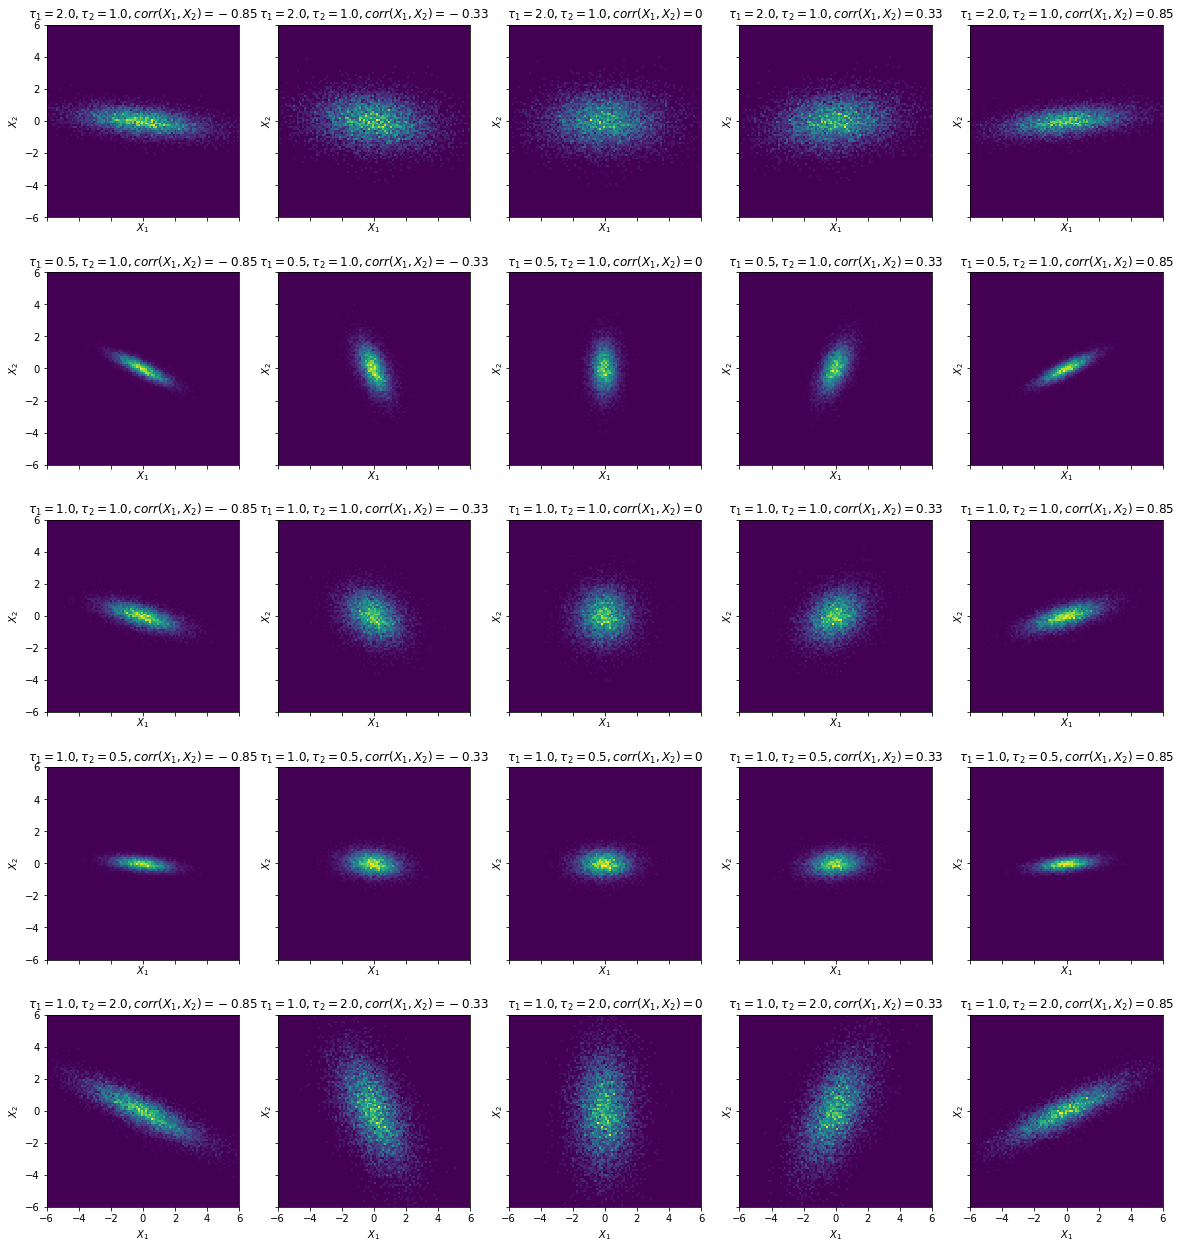

In [57]:

# defining paramaters
mu = np.array([0, 0])
N = len(mu)
c = [-0.85, -0.33, 0, 0.33, 0.85]
shape = np.array([[2, 1], [0.5, 1], [1, 1], [1, 0.5], [1, 2]])



fig, axes = plt.subplots(nrows=len(c),
                         ncols=len(shape),
                         sharex=True,
                         sharey=True,
                         figsize=(20,22))

for i in range(len(c)):
    for j in range(len(shape)):
        _c = c[i]
        _shape = np.diag(shape[j])
        psi = np.array([[1, _c],
                        [_c, 1]])
        L = la.cholesky(psi)
        data = { 'N': N, 'mu': mu, 'L': L, 'diag_T': _shape}
        # sampling from compiled stan model
        sim = multi_normal_sampler.sampling(data=data,
                                            algorithm="Fixed_param",
                                            iter=N_SAMP,
                                            warmup=0,
                                            chains=1,
                                            refresh=N_SAMP,
                                            seed=SEED)
        # extracting from simulation
        params = sim.extract()
        samples = params['samples']
        axes[j,i].hist2d(samples[:,0], samples[:,1], bins=np.linspace(-6,6,100))
        axes[j,i].set_title(r'$\tau_1={}, \tau_2={}, corr(X_1, X_2) = {}$'.format(shape[j][0], shape[j][1], _c))
        axes[j,i].set_xlabel('$X_1$')
        axes[j,i].set_ylabel('$X_2$')
        axes[j,i].set_xlim(-6, 6)
        axes[j,i].set_ylim(-6, 6)
        axes[j,i].set_aspect('equal')

(-6, 6)

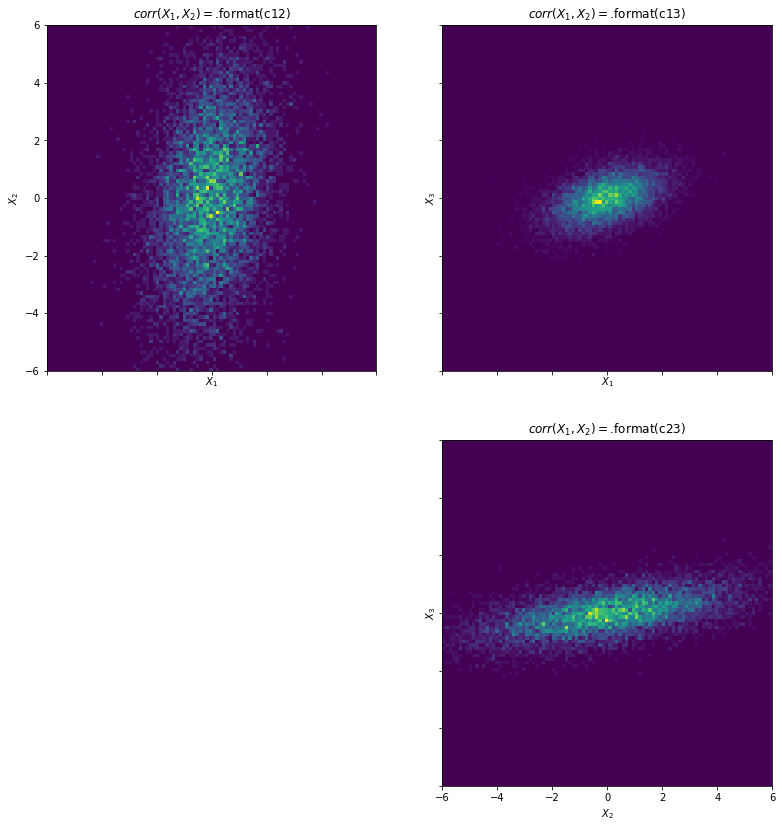

In [67]:

# defining paramaters
mu = np.array([0, 0, 0])
N = len(mu)
c11 = 1
c22 = 1
c33 = 1

c12 = 0
c13 = 0.33
c23 = 0.85

psi = np.array([[c11, c12, c13],
                [c12, c22, c23],
                [c13, c23, c33]])

shape = np.diag(np.array([1, 2, 1.5]))

L = la.cholesky(psi)

data = { 'N': N, 'mu': mu, 'L': L, 'diag_T': shape}

sim = multi_normal_sampler.sampling(data=data,
                                    algorithm="Fixed_param",
                                    iter=N_SAMP,
                                    warmup=0,
                                    chains=1,
                                    refresh=N_SAMP,
                                    seed=SEED)

params = sim.extract()
samples = params['samples']

fig, axes = plt.subplots(nrows=2,
                         ncols=2,
                         sharex=True,
                         sharey=True,
                         figsize=(13,14))


axes[0, 0].hist2d(samples[:,0], samples[:,1], bins=np.linspace(-6,6,100))
axes[0, 0].set_title(r'$corr(X_1, X_2) = {}$.format(c12)')
axes[0, 0].set_xlabel('$X_1$')
axes[0, 0].set_ylabel('$X_2$')
axes[0, 0].set_xlim(-6, 6)
axes[0, 0].set_ylim(-6, 6)

axes[0, 1].hist2d(samples[:,0], samples[:,2], bins=np.linspace(-6,6,100))
axes[0, 1].set_title(r'$corr(X_1, X_2) = {}$.format(c13)')
axes[0, 1].set_xlabel('$X_1$')
axes[0, 1].set_ylabel('$X_3$')
axes[0, 1].set_xlim(-6, 6)
axes[0, 1].set_ylim(-6, 6)

axes[1, 0].remove()


axes[1, 1].hist2d(samples[:,1], samples[:,2], bins=np.linspace(-6,6,100))
axes[1, 1].set_title(r'$corr(X_1, X_2) = {}$.format(c23)')
axes[1, 1].set_xlabel('$X_2$')
axes[1, 1].set_ylabel('$X_3$')
axes[1, 1].set_xlim(-6, 6)
axes[1, 1].set_ylim(-6, 6)

(-6, 6)

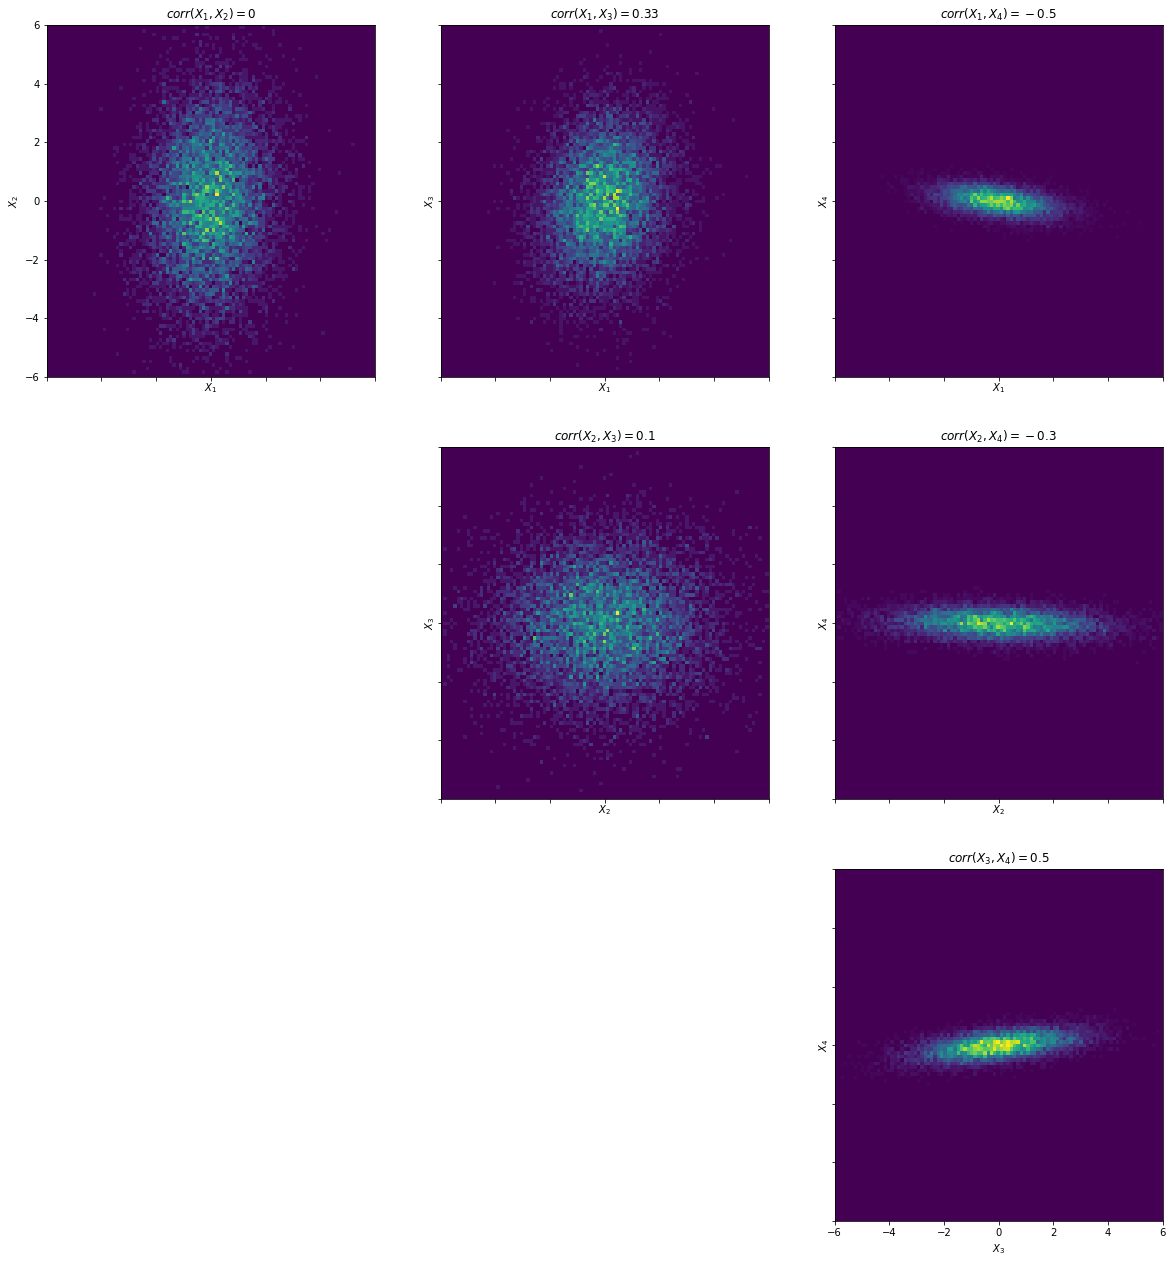

In [65]:

# defining paramaters
mu = np.array([0, 0, 0, 0])
N = len(mu)

c11 = 1
c22 = 1
c33 = 1
c44 = 1

c12 = 0
c13 = 0.33
c14 = -0.5

c23 = 0.1
c24 = -0.3

c34 = 0.5

psi = np.array([[c11, c12, c13, c14],
                [c12, c22, c23, c24],
                [c13, c23, c33, c34],
                [c14, c24, c34, c44]])

shape = np.diag(np.array([1, 2, 1.5, 1]))
L = la.cholesky(psi)

data = { 'N': N, 'mu': mu, 'L': L, 'diag_T': shape}

sim = multi_normal_sampler.sampling(data=data,
                                    algorithm="Fixed_param",
                                    iter=N_SAMP,
                                    warmup=0,
                                    chains=1,
                                    refresh=N_SAMP,
                                    seed=SEED)

params = sim.extract()
samples = params['samples']

fig, axes = plt.subplots(nrows=3,
                         ncols=3,
                         sharex=True,
                         sharey=True,
                         figsize=(20,22))


axes[0, 0].hist2d(samples[:,0], samples[:,1], bins=np.linspace(-6,6,100))
axes[0, 0].set_title(r'$corr(X_1, X_2) = {}$'.format(c12))
axes[0, 0].set_xlabel('$X_1$')
axes[0, 0].set_ylabel('$X_2$')
axes[0, 0].set_xlim(-6, 6)
axes[0, 0].set_ylim(-6, 6)

axes[0, 1].hist2d(samples[:,0], samples[:,2], bins=np.linspace(-6,6,100))
axes[0, 1].set_title(r'$corr(X_1, X_3) = {}$'.format(c13))
axes[0, 1].set_xlabel('$X_1$')
axes[0, 1].set_ylabel('$X_3$')
axes[0, 1].set_xlim(-6, 6)
axes[0, 1].set_ylim(-6, 6)

axes[0, 2].hist2d(samples[:,0], samples[:,3], bins=np.linspace(-6,6,100))
axes[0, 2].set_title(r'$corr(X_1, X_4) = {}$'.format(c14))
axes[0, 2].set_xlabel('$X_1$')
axes[0, 2].set_ylabel('$X_4$')
axes[0, 2].set_xlim(-6, 6)
axes[0, 2].set_ylim(-6, 6)

axes[1, 0].remove()

axes[1, 1].hist2d(samples[:,1], samples[:,2], bins=np.linspace(-6,6,100))
axes[1, 1].set_title(r'$corr(X_2, X_3) = {}$'.format(c23))
axes[1, 1].set_xlabel('$X_2$')
axes[1, 1].set_ylabel('$X_3$')
axes[1, 1].set_xlim(-6, 6)
axes[1, 1].set_ylim(-6, 6)

axes[1, 2].hist2d(samples[:,1], samples[:,3], bins=np.linspace(-6,6,100))
axes[1, 2].set_title(r'$corr(X_2, X_4) = {}$'.format(c24))
axes[1, 2].set_xlabel('$X_2$')
axes[1, 2].set_ylabel('$X_4$')
axes[1, 2].set_xlim(-6, 6)
axes[1, 2].set_ylim(-6, 6)

axes[2,0].remove()

axes[2,1].remove()

axes[2, 2].hist2d(samples[:,2], samples[:,3], bins=np.linspace(-6,6,100))
axes[2, 2].set_title(r'$corr(X_3, X_4) = {}$'.format(c34))
axes[2, 2].set_xlabel('$X_3$')
axes[2, 2].set_ylabel('$X_4$')
axes[2, 2].set_xlim(-6, 6)
axes[2, 2].set_ylim(-6, 6)